In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import sys
import keras
import pickle
from google.colab import drive
import gc

from xgboost import XGBClassifier

drive.mount('/content/drive')
%load_ext tensorboard

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
df3 = pd.read_json('./drive/My Drive/Final_Complied.json', orient='split')# Dataset is now stored in a Pandas Dataframe
del df3["Early Upvotes"]
del df3["Title"]
del df3["Comments"]
del df3["Timestamp"]
del df3["Tags"]
print("Loaded final complied")
f = open("./drive/My Drive/docvec.data", "rb")
vec_data = pickle.load(f)
f.close()
vec_data_df = pd.DataFrame(vec_data)
del vec_data

print("Loaded docvec data")
# df3["class"] = df3["Late Upvotes"].apply(lambda x: 6 if x > 5000 else (5 if x > 1000 else (4 if x > 100 else (3 if x > 20 else (2 if x > 10 else (1 if x > 2 else 0))))))
# df3["class"] = df3["Late Upvotes"].apply(lambda x: 2 if x > 1000 else (1 if x > 100 else 0))
df3["class"] = df3["Late Upvotes"].apply(lambda x: 1 if x > 1000 else (-1 if x > 100 else 0))

df3 = df3[df3["class"] != -1]

vec_data_df = vec_data_df.merge(df3, how="inner", left_index=True, right_index=True)
del vec_data_df["Late Upvotes"]
labels = keras.utils.to_categorical(df3['class'])
print("Made categorical")
x_train, y_train = vec_data_df, labels

del vec_data_df
del labels
del df3

cd = pd.DataFrame(x_train)
cd["score"] = np.argmax(y_train,axis=1)
#print(x_train)

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

size = 300_000
dist = cd.groupby(by="score").count().head(10).iloc[:,0]
dist = np.ceil(size / dist)
print(dist)
equal = pd.DataFrame()
x_test = None
y_test = np.array([])
for g in range(2):
  print(g)
  d = cd[cd["score"] == g]
  test = d.tail(int(len(d) * 0.1))
  y_test = np.append(y_test, test["score"].to_numpy())
  del test["score"]
  if x_test is None:
    x_test = test.to_numpy()
  else: 
    x_test = np.concatenate((x_test, test.to_numpy()))
  equal = pd.concat([equal] + [d.head(int(min(size, len(d)*0.9)))]*int(dist.iloc[g]), ignore_index=True)
  gc.collect()
  print(len(equal))
del d
del cd
#y_train = keras.utils.to_categorical(equal['score'])
#THE FOLLOWING LINE IS EXPERIMENTAL
equal = equal.sample(frac = 1).reset_index(drop=True)
y_train = equal['score']
x_train = pd.DataFrame(equal)
del x_train["score"]
x_train = x_train.to_numpy()
#print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))
#print("Doing split: " + str(type(x_train)) + " " + str(type(y_train)))
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.05, shuffle=False)
#print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))
del equal
#y_test = keras.utils.to_categorical(y_test)

Loaded final complied
Loaded docvec data
Made categorical
[('cd', 2886540240), ('x_train', 2886540240), ('OneHotEncoder', 1056), ('XGBClassifier', 1056), ('f', 176), ('mean_squared_error', 136), ('train_test_split', 136), ('y_train', 112), ('drive', 80), ('np', 80), ('pd', 80), ('xgb', 80)]
score
0      1.0
1    102.0
Name: 0, dtype: float64
0
300000
1
570912


In [3]:
print(x_train.shape)
print(x_train[:10])


(570912, 339)
[[-3.54989577e-04 -4.76512156e-04  1.56977098e-03 ...  0.00000000e+00
   9.00000000e+00  0.00000000e+00]
 [-3.97680153e-04 -8.69074196e-04  9.74271272e-04 ...  0.00000000e+00
   1.20000000e+01  0.00000000e+00]
 [ 2.27315279e-04 -1.29449659e-03 -1.35454547e-03 ...  0.00000000e+00
   1.20000000e+01  0.00000000e+00]
 ...
 [-4.99533955e-04 -7.82228482e-04  4.60602809e-04 ...  0.00000000e+00
   3.50000000e+01  0.00000000e+00]
 [-1.30080990e-03  3.83994367e-04  1.25422655e-03 ...  0.00000000e+00
   1.30000000e+01  0.00000000e+00]
 [ 9.95395239e-05 -8.90205090e-04  1.05674611e-03 ...  0.00000000e+00
   3.90000000e+01  0.00000000e+00]]


In [0]:
print(y_train.shape)
print(y_train[-20:])

(570108,)
570088    0
570089    0
570090    0
570091    0
570092    0
570093    1
570094    0
570095    0
570096    1
570097    1
570098    1
570099    0
570100    1
570101    0
570102    0
570103    0
570104    1
570105    0
570106    1
570107    1
Name: score, dtype: int64


In [4]:
# data_dmatrix_train = xgb.DMatrix(data=x_train,
#                                   label=y_train)
# data_dmatrix_test = xgb.DMatrix(data=x_test,
#                                 label=y_test)


params = {'eta': 0.3, 'max_depth': 3, 'objective': 'multi:softprob',
          'num_class': 2}
x_class = XGBClassifier(max_depth=3, learning_rate = 0.3, num_class = 2, objective = 'multi:softprob')

x_class.fit(x_train, y_train)

#hyperparameters
# xg_reg = xgb.XGBRegressor(objective = "reg:linear", colsample_bytree = 0.3,
#                           learning_rate = 0.1, max_depth = 5, alpha = 10,
#                           n_estimators = 10)
# xg_class = XGBClassifier()
# print(y_train.shape)
# print(X_train.shape)
# xg_class.fit(X_train, y_train)
#
# #print(np.array([X_train]).shape)
# #xg_reg.fit(X_train, y_train)
#
# predictions = xg_class.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=2, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
predictions = x_class.apply(x_test)

In [0]:

rsme = np.sqrt(mean_squared_error(y_test, predictions))
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predictions)
print("RSME:" + str(rsme))
print("Accuracy: " + str(acc))

RSME:0.0364407471708454
Accuracy: 0.9986720719456306


In [0]:
print(predictions[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
print(x_train.shape)
print(y_train[:10])

(570108, 338)
0    0
1    1
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
Name: score, dtype: int64


In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions)
matrix

array([[185005,      0],
       [   246,      0]])

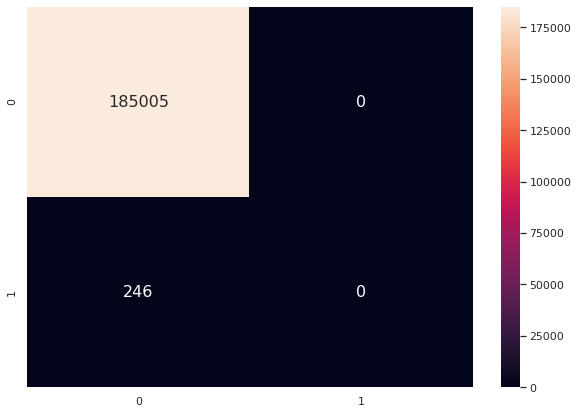

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

In [0]:
from sklearn.metrics import classification_report
print( classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

AxisError: ignored

In [0]:
predictions_train = x_class.predict(x_train)
matrix_train = confusion_matrix(y_train, predictions_train)
matrix_train

array([[300000,      0],
       [270108,      0]])